In [0]:
#imported libraries 
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import itertools 

In [0]:
#combined training and testing sets to have entire dataset to ensure features are the
#same in both train and test sets
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'16N6CwZ16PBfQf1Jj2zEwSBq3bKpYi0gP'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv')
downloaded = drive.CreateFile({'id':'1deEEIhUO5NJGebfWNfS0rzBtZhoPB8zh'})
downloaded.GetContentFile('test.csv')


#3. Read file as panda dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]    

In [5]:
# 1400 is the median so we choose that as the cutoff point of whether an article
# is popular or not, for the classification model we are about to build
# (we could play with this value to make "popularity" more/less exclusive)
for dataset in combine:
    dataset.loc[ dataset[' shares'] <= 1400, ' shares'] = 0
    dataset.loc[ dataset[' shares'] > 1400, ' shares'] = 1
    
# look at first five rows to check that "shares" is now a boolean column
# 0 = unpopular, 1 = popular
train_df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/06/06/social-makeover...,581.0,9.0,645.0,0.523659,1.0,0.705722,9.0,4.0,1.0,...,0.033333,0.8,-0.249653,-0.4,-0.125,0.066667,0.033333,0.433333,0.033333,0
1,http://mashable.com/2013/03/18/gears-of-war-ju...,661.0,11.0,2104.0,0.376261,1.0,0.557325,25.0,3.0,11.0,...,0.100000,1.0,-0.275221,-0.8,-0.050,0.100000,0.000000,0.400000,0.000000,0
2,http://mashable.com/2014/09/17/ios-8-arrives-h...,113.0,10.0,540.0,0.580786,1.0,0.649852,30.0,2.0,1.0,...,0.033333,0.8,-0.300000,-0.8,-0.050,0.900000,0.500000,0.400000,0.500000,0
3,http://mashable.com/2014/09/22/twitter-app-how...,107.0,10.0,711.0,0.530670,1.0,0.668113,21.0,7.0,2.0,...,0.033333,0.8,-0.251282,-0.5,-0.050,0.100000,0.200000,0.400000,0.200000,0
4,http://mashable.com/2014/07/31/doctor-who-prem...,161.0,13.0,796.0,0.473418,1.0,0.624242,12.0,0.0,1.0,...,0.100000,0.6,-0.194753,-0.6,-0.050,0.400000,0.100000,0.100000,0.100000,1


In [0]:
# X sets have only input variables, Y sets have only target variable of shares
# keep only features that have an absolute value for correlation of >0.1 from the log exploratory analysis
################################################################
#CHANGED
################################################################
X_train = train_df[[' global_subjectivity',' weekday_is_sunday',' LDA_01', ' is_weekend', ' data_channel_is_tech',' data_channel_is_lifestyle',' LDA_00', ' data_channel_is_world']] #X_train is the training data withour the 1st and 61st column
Y_train = train_df[' shares']                      #Y_train only contains our target variable
X_test = test_df[[' global_subjectivity',' weekday_is_sunday',' LDA_01', ' is_weekend',  ' data_channel_is_tech',' data_channel_is_lifestyle', ' LDA_00', ' data_channel_is_world']]  #X_test = "Original_data - X_train"
Y_test = test_df[' shares']                        #Y_test is used to verify the accuracy against what we predict later.

In [0]:
# first we try logistic regression (binary classification)
logreg = LogisticRegression() 
logreg.fit(X_train,Y_train)   #Y_train is the dependent variable which is binary. Logistic regression requires the dependent variable to be binary. X_train and Y_train are linearly independent.
Y_pred = logreg.predict(X_test)  #The data in X_test is validated against the model and then the prediction is saved as Y_pred.

In [8]:
import matplotlib.pyplot as plt
from sklearn import metrics

# confusion matrix helps us identify what our model is classifying well and badly
print(metrics.confusion_matrix(Y_test, Y_pred)) #Using the diagonal elements of the confusion matrix we ascertain the correctly classified instances
print(metrics.classification_report(Y_test, Y_pred)) 
acc_log = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2) #Calculating the subset accuracy.
prec_log = round(metrics.precision_score(Y_test, Y_pred) * 100, 2) #Calculating the precision, which is the ability of a model not to label as positive a sample that is negative. 
recall_log = round(metrics.recall_score(Y_test, Y_pred) * 100, 2) #Calculating the recall, which is the ability of the model to find all the positive samples.
f1score_log = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)    #Calculating the F1 score which is the weighted average of precision and recall.
auc_log = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)   #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
train_acc_log = round(logreg.score(X_train, Y_train) * 100, 2) #Calculating the subset accuracy.

[[1957 2098]
 [1194 2680]]
             precision    recall  f1-score   support

          0       0.62      0.48      0.54      4055
          1       0.56      0.69      0.62      3874

avg / total       0.59      0.58      0.58      7929



In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):              #A function that prints and plots the confusion matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]          
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1957 2098]
 [1194 2680]]
Normalized confusion matrix
[[0.48 0.52]
 [0.31 0.69]]


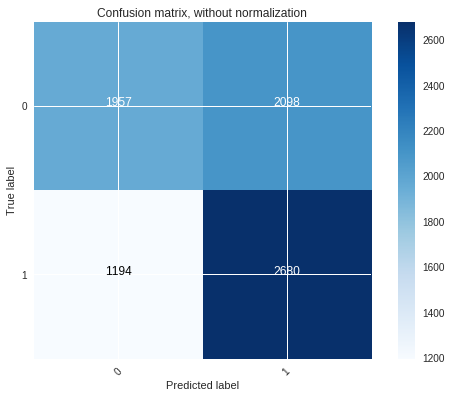

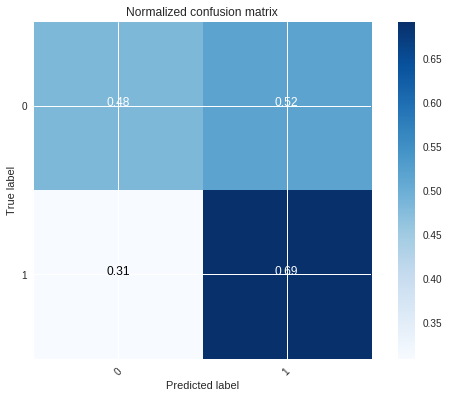

In [10]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
#acc_log is the accuracy of our testing model.
testingacc=acc_log                       
trainingacc=round(logreg.score(X_train,Y_train)*100,2)      #trainingacc is the accuracy of the training model

In [12]:
print(testingacc) #This is how accurately our model predicted the result on test data

58.48


In [13]:
print(trainingacc) #This is how accurately our model predicted the result on training data

59.39


In [14]:
# this will tell us which of the variables are most influential
# we can see from these results that none of the variables are strong correlators

coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by="Correlation", ascending=False)

,Feature,Correlation
3,data_channel_is_tech,0.999107
0,weekday_is_sunday,0.753999
4,data_channel_is_lifestyle,0.270796
6,data_channel_is_world,0.211315
5,LDA_00,0.062885
1,LDA_01,-0.231398
2,is_weekend,-0.912794


Confusion matrix, without normalization
[[1750 2305]
 [ 987 2887]]
Normalized confusion matrix
[[0.43 0.57]
 [0.25 0.75]]


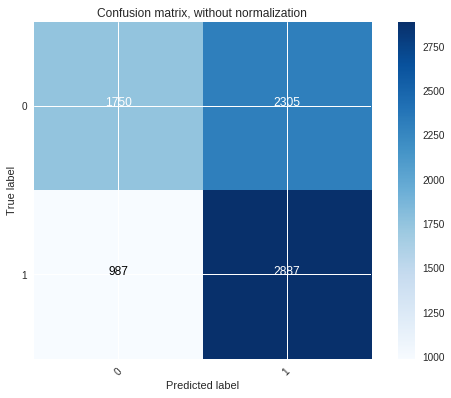

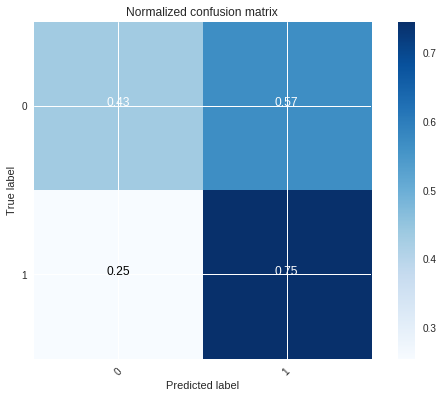

In [15]:
svc = SVC()
svc.fit(X_train, Y_train)  #fit the svc model according to the training data
Y_pred = svc.predict(X_test)  #predict the accuracy on test data
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

acc_svc = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2) 
prec_svc = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_svc = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_svc = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_svc = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_svc = round(svc.score(X_train, Y_train) * 100, 2) 
# so this has classified almost all of the articles as unpopular, so confusion
# matrix is important to include
# this is a BAD model

In [16]:
#K Nearest Neighbor

knn = KNeighborsClassifier(n_neighbors = 3) #Considering 3 nearest neighbors
knn.fit(X_train, Y_train) #Using knn and creating the model on training data 
Y_pred = knn.predict(X_test) #predicting the accuracy of the model on the test data
print(metrics.confusion_matrix(Y_test, Y_pred)) 
print(metrics.classification_report(Y_test, Y_pred))
acc_knn = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_knn = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_knn = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_knn = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_knn = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

[[2309 1746]
 [1772 2102]]
             precision    recall  f1-score   support

          0       0.57      0.57      0.57      4055
          1       0.55      0.54      0.54      3874

avg / total       0.56      0.56      0.56      7929



In [17]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train) #Creating the model using Gaussian Naive Bayes on training data
Y_pred = gaussian.predict(X_test) #Predicting the accuracy of our model
print(metrics.confusion_matrix(Y_test, Y_pred)) 
print(metrics.classification_report(Y_test, Y_pred))
acc_gaussian = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_gaussian = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_gaussian = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_gaussian = round(metrics.f1_score(Y_test, Y_pred) * 100, 2) #weighted average of precision and recall
auc_gaussian = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)




[[2720 1335]
 [1979 1895]]
             precision    recall  f1-score   support

          0       0.58      0.67      0.62      4055
          1       0.59      0.49      0.53      3874

avg / total       0.58      0.58      0.58      7929



In [18]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train) #Creating the model using training data
Y_pred = perceptron.predict(X_test) #predicting the model's accuracy on test data
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.classification_report(Y_test, Y_pred))
acc_perceptron = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_perceptron = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_perceptron = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_perceptron = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_perceptron = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)



[[2828 1227]
 [2419 1455]]
             precision    recall  f1-score   support

          0       0.54      0.70      0.61      4055
          1       0.54      0.38      0.44      3874

avg / total       0.54      0.54      0.53      7929



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [19]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.classification_report(Y_test, Y_pred))
acc_linear_svc = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_linear_svc = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_linear_svc = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_linear_svc = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_linear_svc = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

[[1961 2094]
 [1193 2681]]
             precision    recall  f1-score   support

          0       0.62      0.48      0.54      4055
          1       0.56      0.69      0.62      3874

avg / total       0.59      0.59      0.58      7929



In [20]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.classification_report(Y_test, Y_pred))
acc_sgd = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_sgd = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_sgd = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_sgd = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_sgd = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

[[1006 3049]
 [ 483 3391]]
             precision    recall  f1-score   support

          0       0.68      0.25      0.36      4055
          1       0.53      0.88      0.66      3874

avg / total       0.60      0.55      0.51      7929



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [21]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.classification_report(Y_test, Y_pred))
acc_decision_tree = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_decision_tree = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_decision_tree = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_decision_tree = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_decision_tree = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

[[2235 1820]
 [1800 2074]]
             precision    recall  f1-score   support

          0       0.55      0.55      0.55      4055
          1       0.53      0.54      0.53      3874

avg / total       0.54      0.54      0.54      7929



In [22]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.classification_report(Y_test, Y_pred))
acc_random_forest = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_random_forest = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_random_forest = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_random_forest = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_random_forest = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

[[2427 1628]
 [1636 2238]]
             precision    recall  f1-score   support

          0       0.60      0.60      0.60      4055
          1       0.58      0.58      0.58      3874

avg / total       0.59      0.59      0.59      7929



In [23]:
# AdaBoost

adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train, Y_train)
Y_pred = adaboost.predict(X_test)
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.classification_report(Y_test, Y_pred))
acc_adaboost = round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2)
prec_adaboost = round(metrics.precision_score(Y_test, Y_pred) * 100, 2)
recall_adaboost = round(metrics.recall_score(Y_test, Y_pred) * 100, 2)
f1score_adaboost = round(metrics.f1_score(Y_test, Y_pred) * 100, 2)
auc_adaboost = round(metrics.roc_auc_score(Y_test, Y_pred) * 100, 2)
train_acc_adaboost = round(adaboost.score(X_train, Y_train) * 100, 2)

[[2323 1732]
 [1399 2475]]
             precision    recall  f1-score   support

          0       0.62      0.57      0.60      4055
          1       0.59      0.64      0.61      3874

avg / total       0.61      0.61      0.60      7929



In [24]:
# create a table where we can compare the performance of each model and we see that
# Random Forest performs the best
# test results

models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'AdaBoost'],
    'Accuracy': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_adaboost],
    'Precision': [prec_svc, prec_knn, prec_log, 
              prec_random_forest, prec_gaussian, prec_perceptron, 
              prec_sgd, prec_linear_svc, prec_decision_tree, prec_adaboost],
    'Recall': [recall_svc, recall_knn, recall_log, 
              recall_random_forest, recall_gaussian, recall_perceptron, 
              recall_sgd, recall_linear_svc, recall_decision_tree, recall_adaboost],
    'F1': [f1score_svc, f1score_knn, f1score_log, 
              f1score_random_forest, f1score_gaussian, f1score_perceptron, 
              f1score_sgd, f1score_linear_svc, f1score_decision_tree, f1score_adaboost],
    'AUC': [auc_svc, auc_knn, auc_log, 
              auc_random_forest, auc_gaussian, auc_perceptron, 
              auc_sgd, auc_linear_svc, auc_decision_tree, auc_adaboost]}, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1,AUC
9,AdaBoost,60.51,58.83,63.89,61.25,60.59
3,Random Forest,58.83,57.89,57.77,57.83,58.81
7,Linear SVC,58.54,56.15,69.20,62.00,58.78
0,Support Vector Machines,58.48,55.60,74.52,63.69,58.84
2,Logistic Regression,58.48,56.09,69.18,61.95,58.72
4,Naive Bayes,58.20,58.67,48.92,53.35,58.00
1,KNN,55.63,54.63,54.26,54.44,55.60
6,Stochastic Gradient Decent,55.45,52.66,87.53,65.76,56.17
8,Decision Tree,54.34,53.26,53.54,53.40,54.33
5,Perceptron,54.02,54.25,37.56,44.39,53.65


In [0]:
# dataframe of each model and test accuracy, training accuracy and CV accuracy
# Col 0, 1: from "models" take col 1 and col 2, 
# Col 2: trainingacc=round(logreg.score(X_train,Y_train)*100,2)      #trainingacc is the accuracy of the training model
# Col 3: CV accuracy -  acc_cv_random_forest = round(scores.mean() * 100, 2)

In [0]:
# bargraph of each model and test accuracy, training accuracy and CV accuracy
# VISUALISE

In [27]:
from sklearn.cross_validation import cross_val_score
cv_log = round(cross_val_score(LogisticRegression(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_svc = round(cross_val_score(SVC(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_knn = round(cross_val_score(KNeighborsClassifier(n_neighbors = 3), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_linear_svc = round(cross_val_score(LinearSVC(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_random_forest = round(cross_val_score(RandomForestClassifier(n_estimators=100), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_decision_tree = round(cross_val_score(DecisionTreeClassifier(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_perceptron = round(cross_val_score(Perceptron(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_adaboost = round(cross_val_score(AdaBoostClassifier(n_estimators=100), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_sgd = round(cross_val_score(SGDClassifier(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)
cv_gaussian = round(cross_val_score(GaussianNB(), X_train, Y_train, scoring='accuracy', cv=10).mean() * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stoc

In [28]:
scores = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'AdaBoost'],
    'Test Accuracy': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_adaboost],
    'Train Accuracy': [train_acc_svc, train_acc_knn, train_acc_log, 
              train_acc_random_forest, train_acc_gaussian, train_acc_perceptron, 
              train_acc_sgd, train_acc_linear_svc, train_acc_decision_tree, train_acc_adaboost],
    'CV Train Accuracy': [cv_svc, cv_knn, cv_log, 
              cv_random_forest, cv_gaussian, cv_perceptron, 
              cv_sgd, cv_linear_svc, cv_decision_tree, cv_adaboost]}, columns=['Model', 'Test Accuracy', 'Train Accuracy', 'CV Train Accuracy'])
models.sort_values(by='Test Accuracy', ascending=False)

KeyError: ignored

In [2]:
# CV decreases if the model has memorised the data, so the fact that our CV accuracy
# is slightly higher than accuracy for entire dataset
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(RandomForestClassifier(n_estimators=100), X_train, Y_train, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())
acc_cv_random_forest = round(scores.mean() * 100, 2)
print(acc_cv_random_forest)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: ignored

In [0]:
scores.plot(x="Model", y=["Test Accuracy", "Train Accuracy", "CV Train Accuracy"], kind="bar")

NameError: ignored